# Multi-Layer Perceptrons / Dense Layers

In [1]:
# Setup
import tensorflow as tf
import keras

import time as timer
import datetime

import os
import sys
import imp

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import models as M

imp.reload(M)

/var/folders/b9/jjp98g8j2mbcn65j0fgl0dzw0000gp/T/ipykernel_76623/1920844840.py:10: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


<module 'models' from '/Users/mghifary/Work/Code/AI/keras-poc/models.py'>

### Constants

In [2]:
EPOCH = 30
BATCH = 128

DATADIR = "/Users/mghifary/Work/Code/AI/data"
MODELDIR = "/Users/mghifary/Work/Code/AI/models"

modelpath = os.path.join(MODELDIR, "mnist-mlpbn-classifier.h5")

In [3]:
# Load dataset
data_path = os.path.join(DATADIR, "mnist.npz")
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data(data_path)
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

(n_train, dx1, dx2) = x_train.shape
n_test = x_test.shape[0]

dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Shuffle and batch
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH)
dataset_test = dataset_test.batch(BATCH)

In [4]:
# Build model
model = M.MLPBN(num_classes=10)
model.build(input_shape=(None, dx1, dx2))
model.summary()

Model: "mlpbn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  401920    
                                                                 
 layer_normalization (Layer  multiple                  1024      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             multiple                  131328    
                                                                 
 layer_normalization_1 (Lay  multiple                  512       
 erNormalization)                                                
                                                                 
 dense_2 (Dense)             multiple                  32896 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 layer_normalization (Layer  (None, 512)               1024      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 layer_normalization_1 (Lay  (None, 256)               512       
 erNormalization)                                            

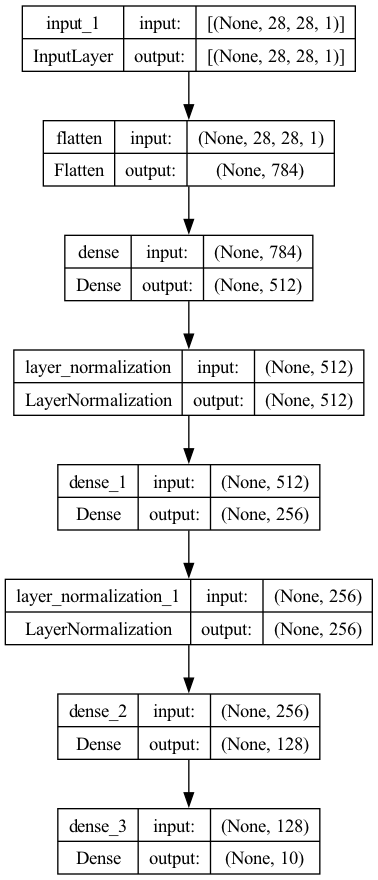

In [5]:
inputs = keras.Input(shape=(dx1, dx2, 1))
model_func = keras.Model(inputs, model.call(inputs))
print(model_func.summary())
modelfig_path = os.path.join(MODELDIR, "mlpbn_mnist.png")
keras.utils.plot_model(model_func, to_file=modelfig_path, show_shapes=True)

Train model

In [6]:
# Loss and optimizer
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = keras.optimizers.legacy.Adam(learning_rate=3e-4)


In [7]:
# Define metrics
train_loss = keras.metrics.Mean('train_loss', dtype=tf.float32)
train_accuracy = keras.metrics.SparseCategoricalAccuracy('train_accuracy')

test_loss = keras.metrics.Mean('test_loss', dtype=tf.float32)
test_accuracy = keras.metrics.SparseCategoricalAccuracy('test_accuracy')

In [8]:
# Training and test function
@tf.function
def train_on_batch(model, loss_fn, optimizer, x, y):
    with tf.GradientTape() as tape:
        y_pred = model(x, training=True)
        loss_value = loss_fn(y, y_pred)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    train_loss(loss_value)
    train_accuracy(y, y_pred)

@tf.function
def test_on_batch(model, loss_fn, x, y):
    y_pred = model(x, training=False)
    loss_value = loss_fn(y, y_pred)
    
    test_loss(loss_value)
    test_accuracy(y, y_pred)

In [9]:
# Setup summary writers
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/mlp-mnist/' + current_time + '/train'
test_log_dir = 'logs/mlp-mnist/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [10]:
# Do training
for epoch in range(EPOCH):
    # Mini-batch training
    train_duration = 0.0
    for step, (x, y) in enumerate(dataset):
        start_t = timer.time()
        train_on_batch(model, loss_fn, optimizer, x, y)
        elapsed_t = timer.time() - start_t

        train_duration += elapsed_t
    
    # Store log
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)

    # Test
    test_duration = 0.0
    for step, (xt, yt) in enumerate(dataset_test):
        start_t = timer.time()
        test_on_batch(model, loss_fn, xt, yt)
        elapsed_t = timer.time() - start_t

        test_duration += elapsed_t

    # Store log
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', test_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', test_accuracy.result(), step=epoch)

    print(f"Epoch {epoch+1} - Training [loss: {train_loss.result():.5f}, accuracy: {train_accuracy.result():.3f}] ({train_duration:.3f} secs), Test [loss: {test_loss.result():.5f}. accuracy: {test_accuracy.result():.3f}] ({test_duration:.3f} secs)")

    # Save model
    model.save_weights(modelpath, overwrite=True, save_format=None, options=None)

# end of epoch

Epoch 1 - Training [loss: 0.23166, accuracy: 0.930] (3.471 secs), Test [loss: 0.13180. accuracy: 0.961] (0.428 secs)
Epoch 2 - Training [loss: 0.17115, accuracy: 0.948] (3.033 secs), Test [loss: 0.12255. accuracy: 0.963] (0.195 secs)
Epoch 3 - Training [loss: 0.14190, accuracy: 0.957] (3.035 secs), Test [loss: 0.11629. accuracy: 0.964] (0.196 secs)
Epoch 4 - Training [loss: 0.12335, accuracy: 0.963] (3.033 secs), Test [loss: 0.11210. accuracy: 0.965] (0.198 secs)
Epoch 5 - Training [loss: 0.11006, accuracy: 0.967] (3.032 secs), Test [loss: 0.10727. accuracy: 0.966] (0.195 secs)
Epoch 6 - Training [loss: 0.09986, accuracy: 0.970] (3.034 secs), Test [loss: 0.10449. accuracy: 0.967] (0.197 secs)
Epoch 7 - Training [loss: 0.09156, accuracy: 0.972] (3.034 secs), Test [loss: 0.10303. accuracy: 0.968] (0.194 secs)
Epoch 8 - Training [loss: 0.08488, accuracy: 0.974] (3.069 secs), Test [loss: 0.10232. accuracy: 0.968] (0.197 secs)
Epoch 9 - Training [loss: 0.07916, accuracy: 0.976] (3.100 secs)